In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import tensorflow as tf 
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
(x_train_ori, y_train_ori), (x_test_ori, y_test_ori) = tf.keras.datasets.mnist.load_data()
test_data_path = 'data/MNIST_Test_Nox16.mat'
train_data_path = 'data/MNIST_Train_Nox16.mat'

In [3]:
test_data = loadmat(test_data_path)
train_data = loadmat(train_data_path)

x_train_ori = train_data['VV']/255.0
x_test_ori = test_data['UU']/255.0

In [4]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y.astype(int)

x_train, y_train = filter_36(x_train_ori, y_train_ori)
x_test, y_test = filter_36(x_test_ori, y_test_ori)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


In [5]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(16, 1)),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

# Train the model
nn_history = model.fit(x_train,
                       y_train,
                       batch_size=128,
                       epochs=15, 
                       validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
95/95 [==============================] - 1s 3ms/step - loss: 0.3470 - accuracy: 0.9017 - val_loss: 0.1266 - val_accuracy: 0.9751
Epoch 2/15
95/95 [==============================] - 0s 1ms/step - loss: 0.0979 - accuracy: 0.9783 - val_loss: 0.0745 - val_accuracy: 0.9792
Epoch 3/15
95/95 [==========================

In [6]:
# A network with two layers. The first layer has three neurons and the second layer has one neuron.
structure = [3, 1]

# Initialize the device with a dynamic number of wires
input_dimension = int(np.log2(len(x_train[0])))
num_qubits = sum(structure) + input_dimension + 1  # input qubit + label qubit
num_layers = 2
dev = qml.device("default.qubit", wires=num_qubits)

In [7]:
def qn_U3(paras, control_q, ancila):
    for i in range(len(control_q)):
        qml.CRY(paras[i], wires=[control_q[i], ancila])
    qml.U3(paras[len(control_q)], paras[len(control_q)+1], 
           paras[len(control_q)+2], ancila)

def qn_RY(paras, control_q, ancila):
    for i in range(len(control_q)):
        qml.CRY(paras[i], wires=[control_q[i], ancila])
    qml.RZ(paras[len(control_q)], ancila)
    qml.RY(paras[len(control_q)+1], ancila)

def layer(paras, qubits):
    for i in range(len(qubits)):
        qml.RY(paras[2*i], wires=[qubits[i]])
        qml.RZ(paras[2*i+1], wires=[qubits[i]])
    
    for i in range(len(qubits)):   
        if i != len(qubits)-1:
            qml.CNOT(wires=[qubits[i], qubits[i+1]])

In [8]:
@qml.qnode(dev, interface="autograd")
def circuit(paras, f, label=None, structure=structure, input_type="individual"):
    # Choose the right qn function
    qn = qn_RY
    gate_params = 2

    # Embedding the initial state based on the input type
    if input_type == "individual":
        wires_for_embedding = list(range(input_dimension))
    elif input_type == "superposition":
        wires_for_embedding = list(range(input_dimension)) + [num_qubits-1]
    else:
        raise ValueError(f"Invalid input type: {input_type}")
        
    qml.AmplitudeEmbedding(features=f, wires=wires_for_embedding, normalize=True)

    idx = 0
    ancila_start = input_dimension
    control_q = range(input_dimension) # input quibit

    for _ in range(num_layers):
        layer(paras[idx:idx+8], control_q)
        idx += 8

    for i in range(len(control_q)):
        qml.RY(paras[idx+2*i], wires=[control_q[i]])
        qml.RZ(paras[idx+2*i+1], wires=[control_q[i]])
    
    idx += 8

    for num_neurons in structure:
        new_control_q = []
        for _ in range(num_neurons):
            qn(paras[idx:idx+len(control_q)+gate_params], control_q, ancila_start)
            idx += len(control_q) + gate_params
            new_control_q.append(ancila_start)
            ancila_start += 1
        control_q = new_control_q

    # Conditional Pauli-X gate application
    if label == 1:
        qml.PauliX(wires=ancila_start)

    return qml.expval(qml.PauliZ(ancila_start - 1) @ qml.PauliZ(ancila_start))

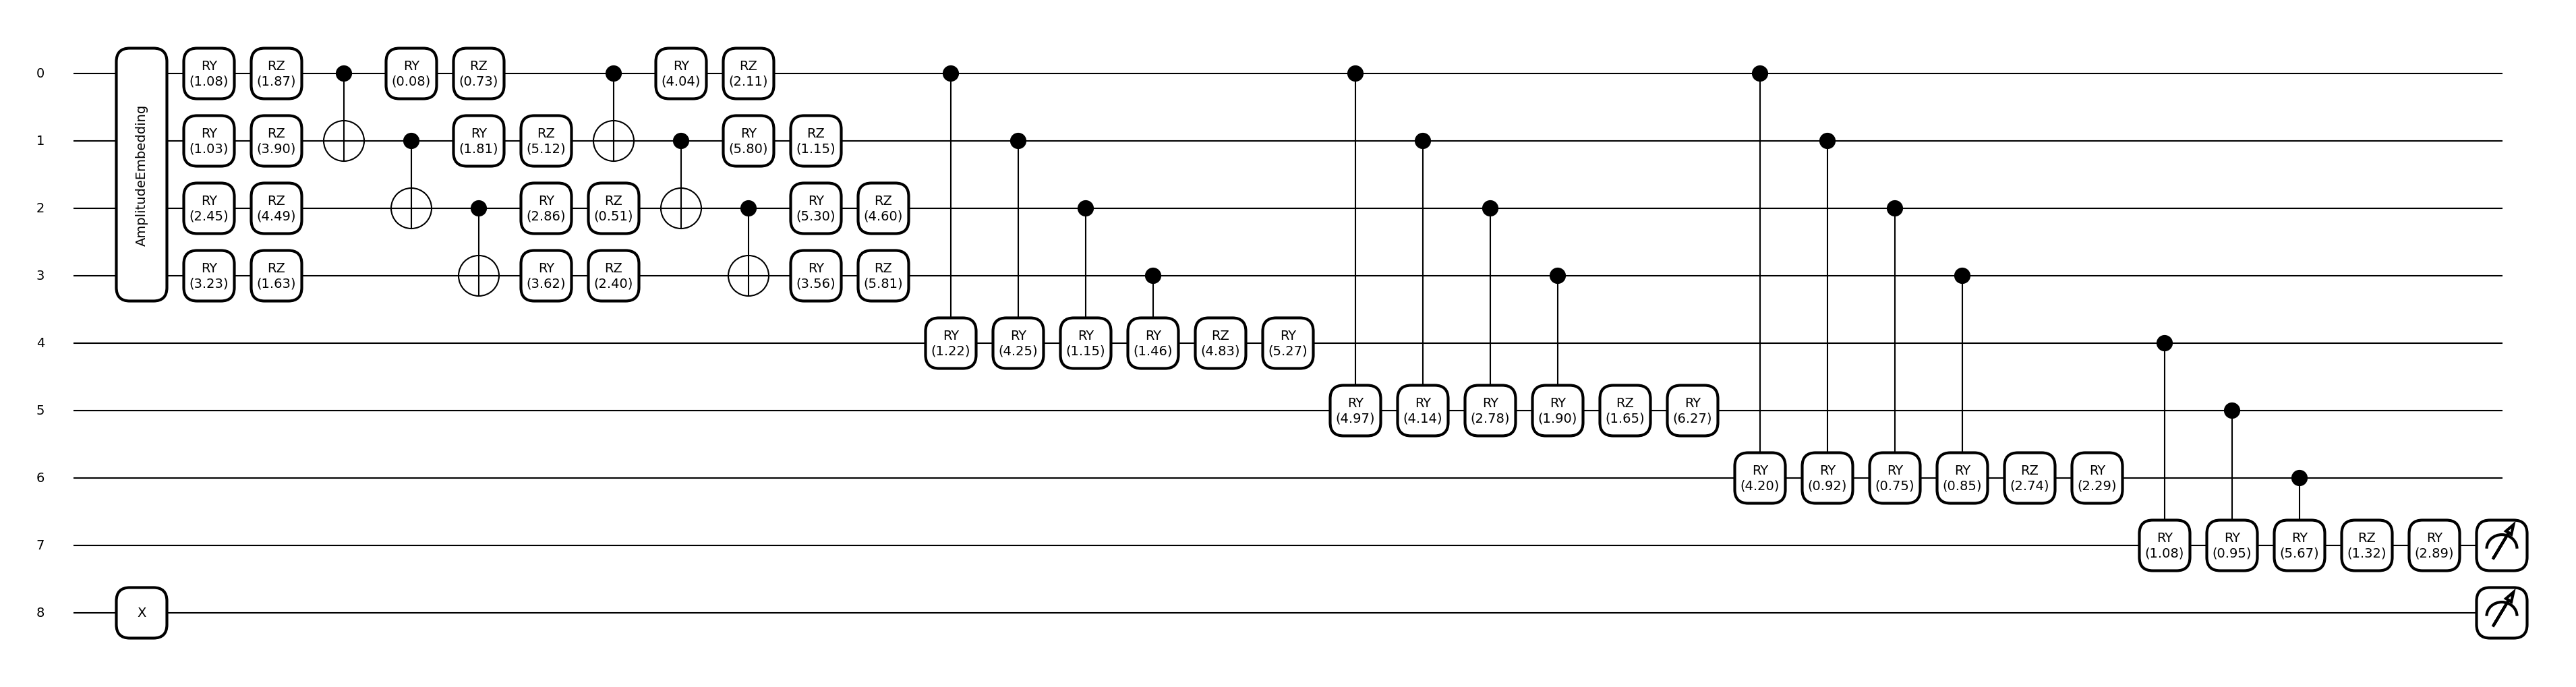

In [9]:
# Random initialization of parameters for U3
paras_num = (num_layers+1)*8 + sum(structure)*6 - 1
paras_init = np.random.uniform(low=0.0, high=2*np.pi, size=paras_num)

# Draw the executed quantum circuit:
fig, ax = qml.draw_mpl(circuit, decimals=2)(paras_init,
                                            f=x_train[0],
                                            label=1)
plt.show()

In [10]:
def sum_loss(predictions):
    loss = -np.sum(predictions)
    return loss / len(predictions)

def accuracy(predictions):
    acc = 0
    for p in predictions:
        if p > 0:
            acc = acc + 1
    return acc / len(predictions)

def cost(paras, features, labels):
    predictions = [circuit(paras, f, label) for (f, label) in zip (features, labels)]
    return sum_loss(predictions)

def cost_s(paras, features):
    prediction = [circuit(paras, f=features, input_type="superposition")]
    return sum_loss(prediction)

In [11]:
# epoch作为衡量
opt = AdamOptimizer(0.01)
num_train = len(x_train)
num_epochs = 15
batch_size = 128

# train the variational classifier
paras = paras_init
cost_test_i, acc_test_i = [], []
cost_train_i, acc_train_i = [], []
num_batches = num_train // batch_size  # Determine number of batches

# use superposition input to train the variational classifier
paras_s = paras_init
cost_test_sup, acc_test_sup = [], []
cost_train_sup, acc_train_sup = [], []

for epoch in range(num_epochs):
    # Shuffle the training data
    permutation = np.random.permutation(num_train)
    x_train_shuffled = x_train[permutation]
    y_train_shuffled = y_train[permutation]

    for batch_idx in range(num_batches):
        # Compute start and end indices for batch
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        
        # If end index goes beyond the number of training samples, clip it
        if end_idx > num_train:
            end_idx = num_train
        
        x_train_batch = x_train_shuffled[start_idx:end_idx]
        y_train_batch = y_train_shuffled[start_idx:end_idx]
         
        paras = opt.step(lambda v: cost(v, x_train_batch, y_train_batch), paras)

        # Get the samples where Y_train equals 1 and sum them
        x_train_1 = x_train_batch[y_train_batch == 1]
        sum_x_train_1 = np.sum(x_train_1, axis=0)  # Sum over samples
        # Get the samples where Y_train equals 0 and sum them
        x_train_0 = x_train_batch[y_train_batch == 0]
        sum_x_train_0 = np.sum(x_train_0, axis=0)  # Sum over samples
        
        # creat the superposition state
        x_train_batch_s = []
        for i in range(16):
            x_train_batch_s.append(sum_x_train_0[i])
            x_train_batch_s.append(sum_x_train_1[i])
        
        paras_s = opt.step(lambda v: cost_s(v,x_train_batch_s), paras_s)

    # Compute predictions on train and validation set
    predictions_train = [circuit(paras, f, label) for (f, label) in zip (x_train, y_train)]
    predictions_test = [circuit(paras, f, label) for (f, label) in zip (x_test, y_test)]
        
    # Compute accuracy on train and validation set
    acc_train = accuracy(predictions_train)
    acc_test = accuracy(predictions_test)
    acc_train_i.append(acc_train)
    acc_test_i.append(acc_test)

    cost_train = sum_loss(predictions_train)
    cost_test = sum_loss(predictions_test)
    cost_train_i.append(cost_train)
    cost_test_i.append(cost_test)
    print(
        "Iter: {:5d} | Cost train: {:0.7f} | Cost test: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} "
        "".format(epoch + 1, cost_train, cost_test, acc_train, acc_test)
    )

    # Compute predictions on train and validation set
    predictions_train = [circuit(paras_s, f, label) for (f, label) in zip (x_train, y_train)]
    predictions_test = [circuit(paras_s, f, label) for (f, label) in zip (x_test, y_test)]
            
    # Compute accuracy on train and validation set
    acc_train = accuracy(predictions_train)
    acc_test = accuracy(predictions_test)
    acc_train_sup.append(acc_train)
    acc_test_sup.append(acc_test)

    cost_train = sum_loss(predictions_train)
    cost_test = sum_loss(predictions_test)
    cost_train_sup.append(cost_train)
    cost_test_sup.append(cost_test)
    print(
        "Iter: {:5d} | Cost train: {:0.7f} | Cost test: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} "
        "".format(epoch + 1, cost_train, cost_test, acc_train, acc_test)
    )

Iter:     1 | Cost train: -0.3901031 | Cost test: -0.3962474 | Acc train: 0.9770935 | Acc test: 0.9766260 
Iter:     1 | Cost train: -0.3909570 | Cost test: -0.3970482 | Acc train: 0.9756826 | Acc test: 0.9766260 
Iter:     2 | Cost train: -0.4223825 | Cost test: -0.4311776 | Acc train: 0.9730268 | Acc test: 0.9715447 
Iter:     2 | Cost train: -0.4223302 | Cost test: -0.4309099 | Acc train: 0.9721969 | Acc test: 0.9715447 
Iter:     3 | Cost train: -0.4327493 | Cost test: -0.4409107 | Acc train: 0.9757656 | Acc test: 0.9710366 
Iter:     3 | Cost train: -0.4323591 | Cost test: -0.4403488 | Acc train: 0.9746037 | Acc test: 0.9710366 
Iter:     4 | Cost train: -0.4354981 | Cost test: -0.4439971 | Acc train: 0.9734418 | Acc test: 0.9725610 
Iter:     4 | Cost train: -0.4350824 | Cost test: -0.4432856 | Acc train: 0.9724458 | Acc test: 0.9725610 
Iter:     5 | Cost train: -0.4364396 | Cost test: -0.4440349 | Acc train: 0.9751847 | Acc test: 0.9725610 
Iter:     5 | Cost train: -0.4356344 